# Rating data analyses

This notebook performs the following analysis steps:
* Data importing, preprocessing & cleaning
* Find out which rating scale works out for which model
    * Aggregating data by phenomenon, by model, by scale on weighted score of target option
    * Generate a plot accordingly
    * Subset the data for further analysis
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import numpy as np


## Import & preprocess the data set

In [2]:
# Define the path to the 'rating' subfolder
rating_folder_path = "../results/rating"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(rating_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Read and concatenate all CSV files
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the shape and a sample of the concatenated DataFrame
shape = concatenated_df.shape
sample_data = concatenated_df.head()

shape, sample_data

((7692, 17),
                  model_name  temperature  seed  item_id       phenomenon  \
 0  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 1  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 2  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 3  meta-llama/Llama-2-7b-hf          0.1     0        1  indirect_speech   
 4  meta-llama/Llama-2-7b-hf          0.1     0        2  indirect_speech   
 
                                               prompt  \
 0  You will read a short story that describes an ...   
 1  You will read a short story that describes an ...   
 2  You will read a short story that describes an ...   
 3  You will read a short story that describes an ...   
 4  You will read a short story that describes an ...   
 
                                         prior_prompt question  \
 0  You will read a short story that describes an ...      NaN   
 1  You will read a short story that describes 

In [3]:
# Checking for NA values in the concatenated DataFrame
na_values = concatenated_df.isnull().sum()

na_values


model_name                       0
temperature                      0
seed                             0
item_id                          0
phenomenon                       0
prompt                           0
prior_prompt                     0
question                      5820
options                          0
option_names                     0
scale                            0
rating_options                   0
weighted_options                 0
chosen_option                    0
token_cond_log_probs             0
prior_token_log_probs            0
null_prior_token_log_probs       0
dtype: int64

In [4]:
# Grouping by the specified columns and calculating mean and standard deviation for 'weighted_options'
grouped_df = concatenated_df.groupby(['phenomenon', 'option_names', 'item_id', 'model_name', 'scale'])['weighted_options'].agg(['mean'])

grouped_df.reset_index(inplace=True)
grouped_df.head()


print(grouped_df.shape)
print(grouped_df.isnull().sum())
print(grouped_df.head())

(7692, 6)
phenomenon      0
option_names    0
item_id         0
model_name      0
scale           0
mean            0
dtype: int64
  phenomenon option_names  item_id              model_name        scale  \
0  coherence   competitor        1       google/flan-t5-xl  appropriate   
1  coherence   competitor        1       google/flan-t5-xl       likely   
2  coherence   competitor        1       google/flan-t5-xl    plausible   
3  coherence   competitor        1       google/flan-t5-xl     possible   
4  coherence   competitor        1  gpt-3.5-turbo-instruct  appropriate   

       mean  
0  3.147568  
1  2.909551  
2  3.006738  
3  2.923203  
4  2.769090  


## Plot of weighted score of target response against rating scales grouped by phenomenon and model

In [5]:
# Filtering the data for rows where option_names is 'target'
target_data = concatenated_df[concatenated_df['option_names'] == 'target']

# Grouping by scale, model_name, and phenomenon and calculating mean and standard deviation for weighted_options
grouped_target_data = target_data.groupby(['scale', 'model_name', 'phenomenon'])['weighted_options'].agg(['mean', 'std']).reset_index()

print(grouped_target_data.head())


         scale         model_name       phenomenon      mean       std
0  appropriate  google/flan-t5-xl        coherence  2.998544  0.086520
1  appropriate  google/flan-t5-xl          deceits  2.898867  0.110442
2  appropriate  google/flan-t5-xl           humour  2.789100  0.134618
3  appropriate  google/flan-t5-xl  indirect_speech  2.989182  0.140188
4  appropriate  google/flan-t5-xl            irony  2.985433  0.114254


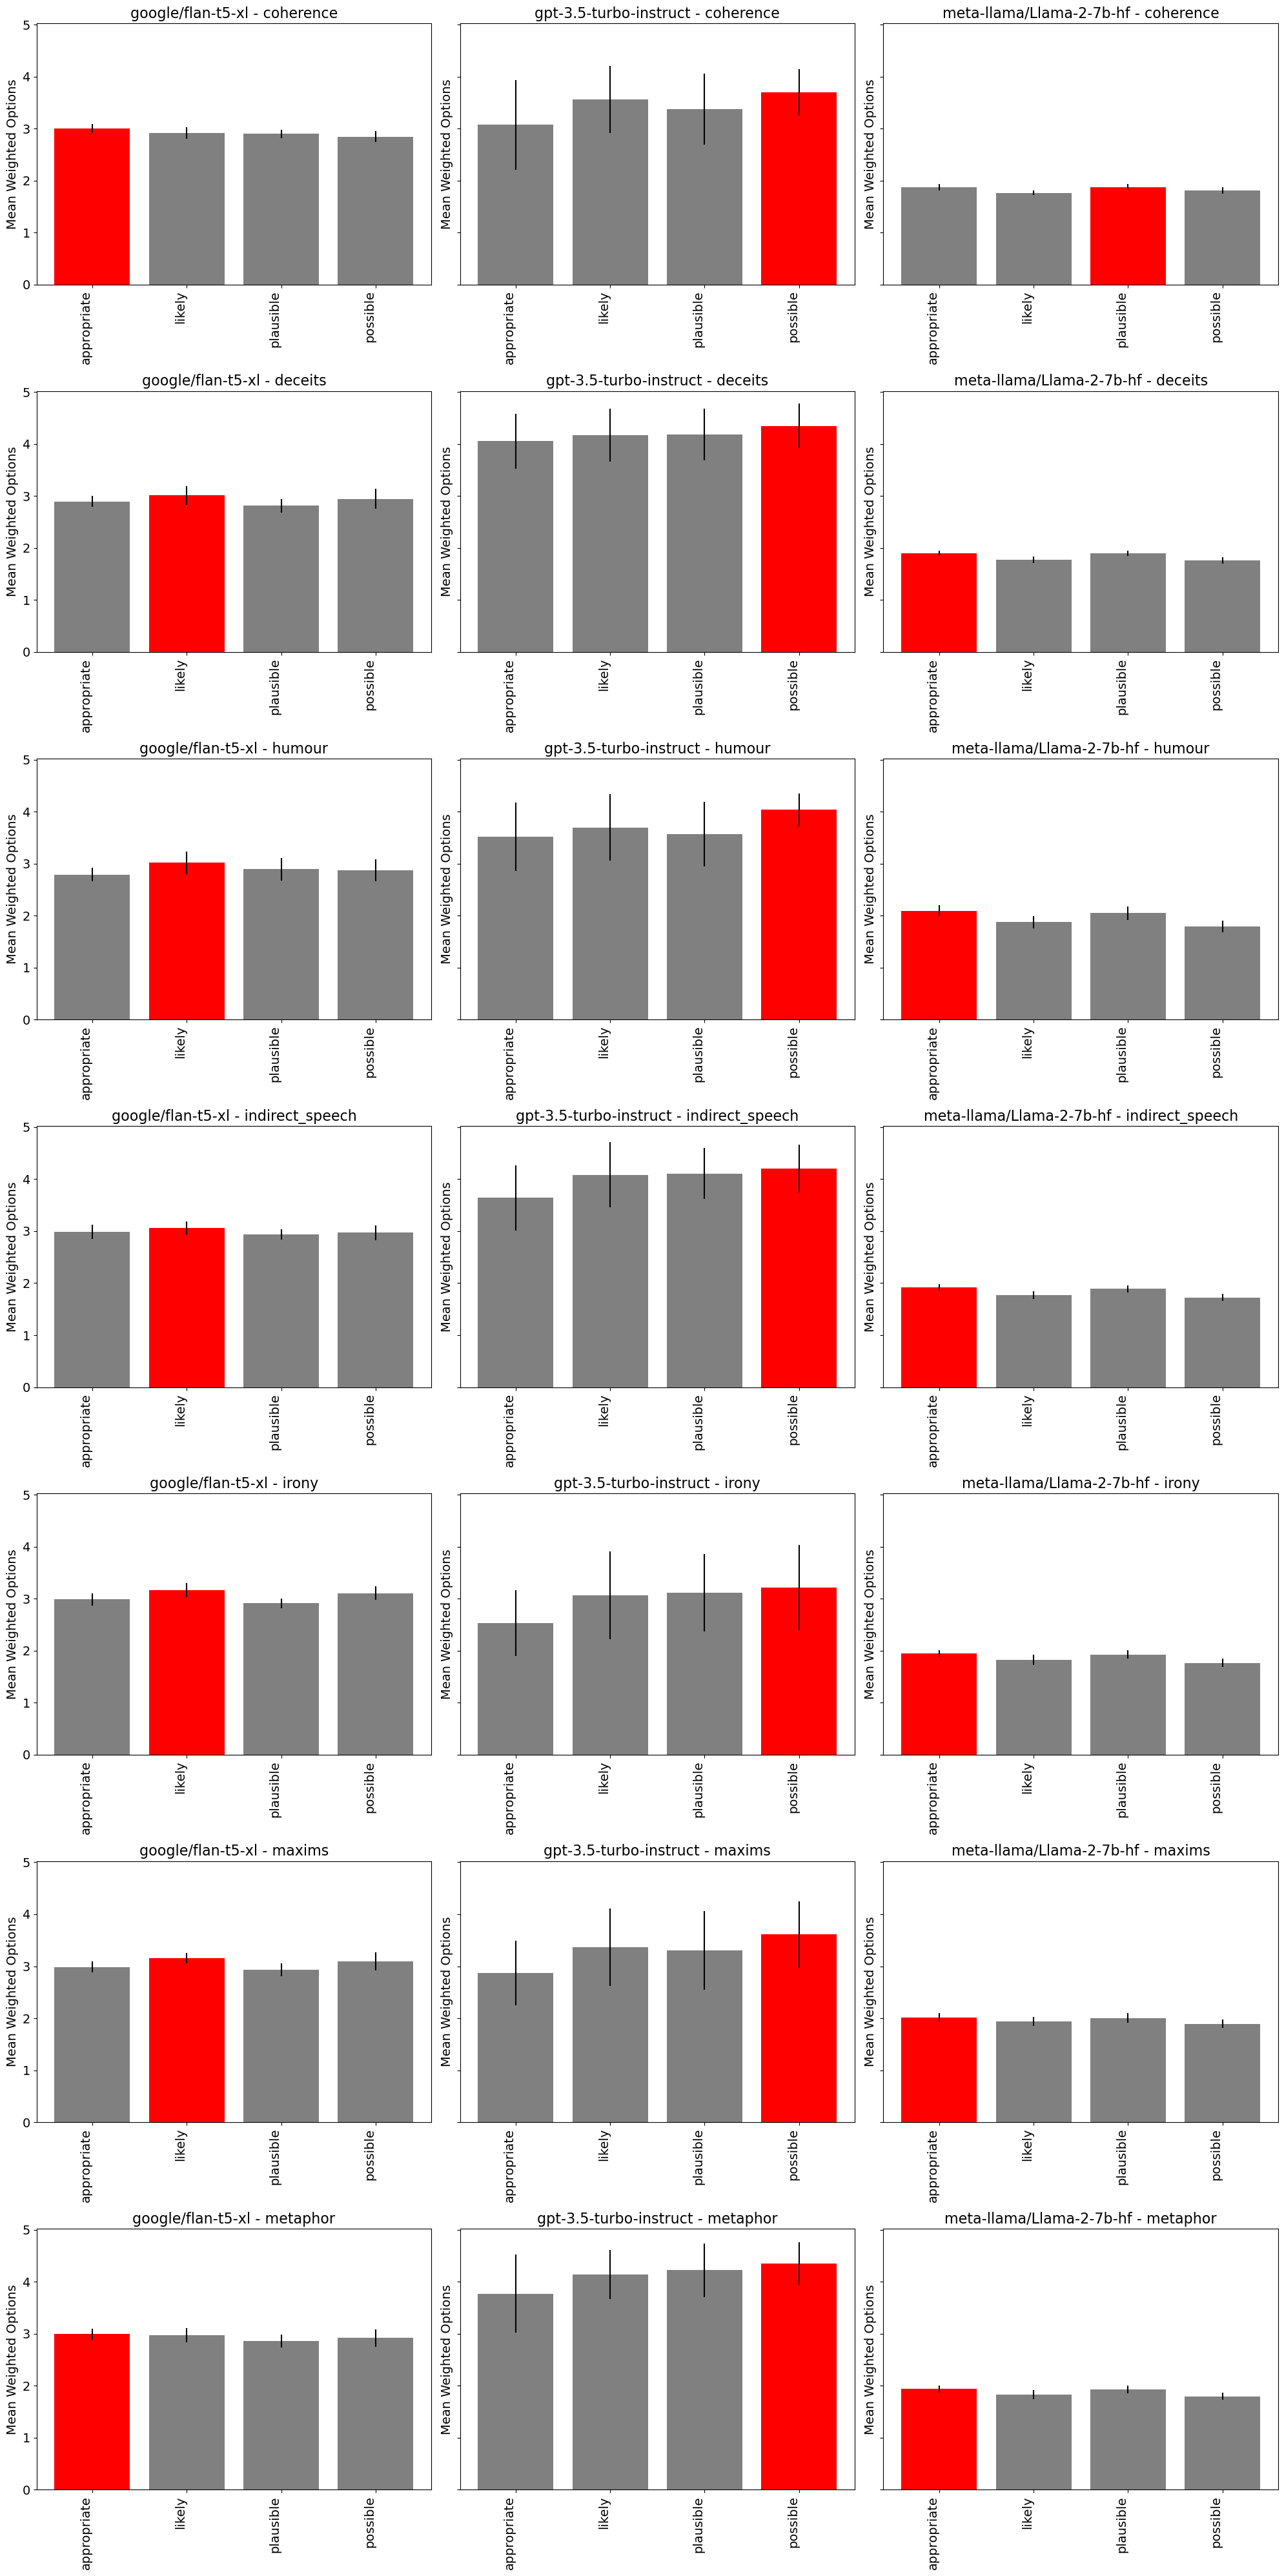

In [6]:
# Extracting unique models and phenomena based on the grouped data
unique_models = grouped_df['model_name'].unique()
unique_phenomena = grouped_df['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in grouped_df['option_names'].unique()}

# Manually creating a grid of subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterating over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_target_data[(grouped_target_data['model_name'] == model) & 
                                     (grouped_target_data['phenomenon'] == phenomenon)]
        
        # Determining the bar color based on the highest mean
        colors = ['red' if val == subset['mean'].max() else 'gray' for val in subset['mean']]
        
        ax.bar(subset['scale'], subset['mean'], color=colors, yerr=subset['std'])
        ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
        ax.set_xlabel('')
        ax.set_ylabel('Mean Weighted Options')

        # Use FixedLocator to set ticks
        ax.xaxis.set_major_locator(FixedLocator(range(len(subset['scale']))))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

       # Remove all lines on background
        ax.grid(False)
        #sns.despine(left=True, bottom=True, ax=ax)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

        
# Adjust layout
fig.tight_layout()
plt.show()

In [7]:
# Define the path to save the plot as PDF
save_path = "plots/rating_w.score_scale_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_w.score_scale_by_model_phenomenon.pdf'

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model for all three factors
model = ols('weighted_options ~ scale * phenomenon * model_name', data=target_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# There is no sig. three way interaction, subset the data for two way interaction

# Subset the data in models
target_data_t5 = target_data[target_data['model_name'] == 'google/flan-t5-xl']
target_data_gpt = target_data[target_data['model_name'] == 'gpt-3.5-turbo-instruct']
target_data_llama = target_data[target_data['model_name'] == 'meta-llama/Llama-2-7b-hf']

# Fit the model respectively
model_t5 = ols('weighted_options ~ scale * phenomenon', data=target_data_t5).fit()
model_gpt = ols('weighted_options ~ scale * phenomenon', data=target_data_gpt).fit()
model_llama = ols('weighted_options ~ scale * phenomenon', data=target_data_llama).fit()

# Perform ANOVA and print the table
anova_table_t5 = sm.stats.anova_lm(model_t5, typ=2)
print(anova_table_t5)

anova_table_gpt = sm.stats.anova_lm(model_gpt, typ=2)
print(anova_table_gpt)

anova_table_llama = sm.stats.anova_lm(model_llama, typ=2)
print(anova_table_llama)


                                  sum_sq      df            F         PR(>F)
scale                           5.613683     3.0    13.223869   1.512351e-08
phenomenon                     31.919639     6.0    37.595737   2.365187e-43
model_name                   1058.827288     2.0  3741.338651   0.000000e+00
scale:phenomenon                1.307942    18.0     0.513509   9.534336e-01
scale:model_name               28.689352     6.0    33.791026   5.707886e-39
phenomenon:model_name          85.966651    12.0    50.626821  9.134464e-106
scale:phenomenon:model_name     5.480133    36.0     1.075773   3.494985e-01
Residual                      275.083391  1944.0          NaN            NaN
                     sum_sq     df          F        PR(>F)
scale              1.613715    3.0  28.208081  3.743955e-17
phenomenon         2.210899    6.0  19.323491  8.715447e-21
scale:phenomenon   1.918512   18.0   5.589332  2.082910e-12
Residual          12.356832  648.0        NaN           NaN
       

## Plot of argmax weighted score against option names grouped by phenomenon and model

In [9]:
# Define conditions to subset the df for further analysis
conditions = [
    (concatenated_df['model_name'] == "google/flan-t5-xl") & (concatenated_df['scale'] == "likely"),
    (concatenated_df['model_name'] == "gpt-3.5-turbo-instruct") & (concatenated_df['scale'] == "possible"),
    (concatenated_df['model_name'] == "meta-llama/Llama-2-7b-hf") & (concatenated_df['scale'] == "appropriate")
]

combined_conditions = conditions[0] | conditions[1] | conditions[2]

# Apply the subsetting conditions based on model_name and scale
df_no_scale = concatenated_df[combined_conditions]

# Grouping by model_name, and phenomenon and calculating mean and standard deviation for weighted_options
grouped_df_no_scale = df_no_scale.groupby(['model_name', 'phenomenon', 'option_names'])['weighted_options'].agg(['mean', 'std']).reset_index()



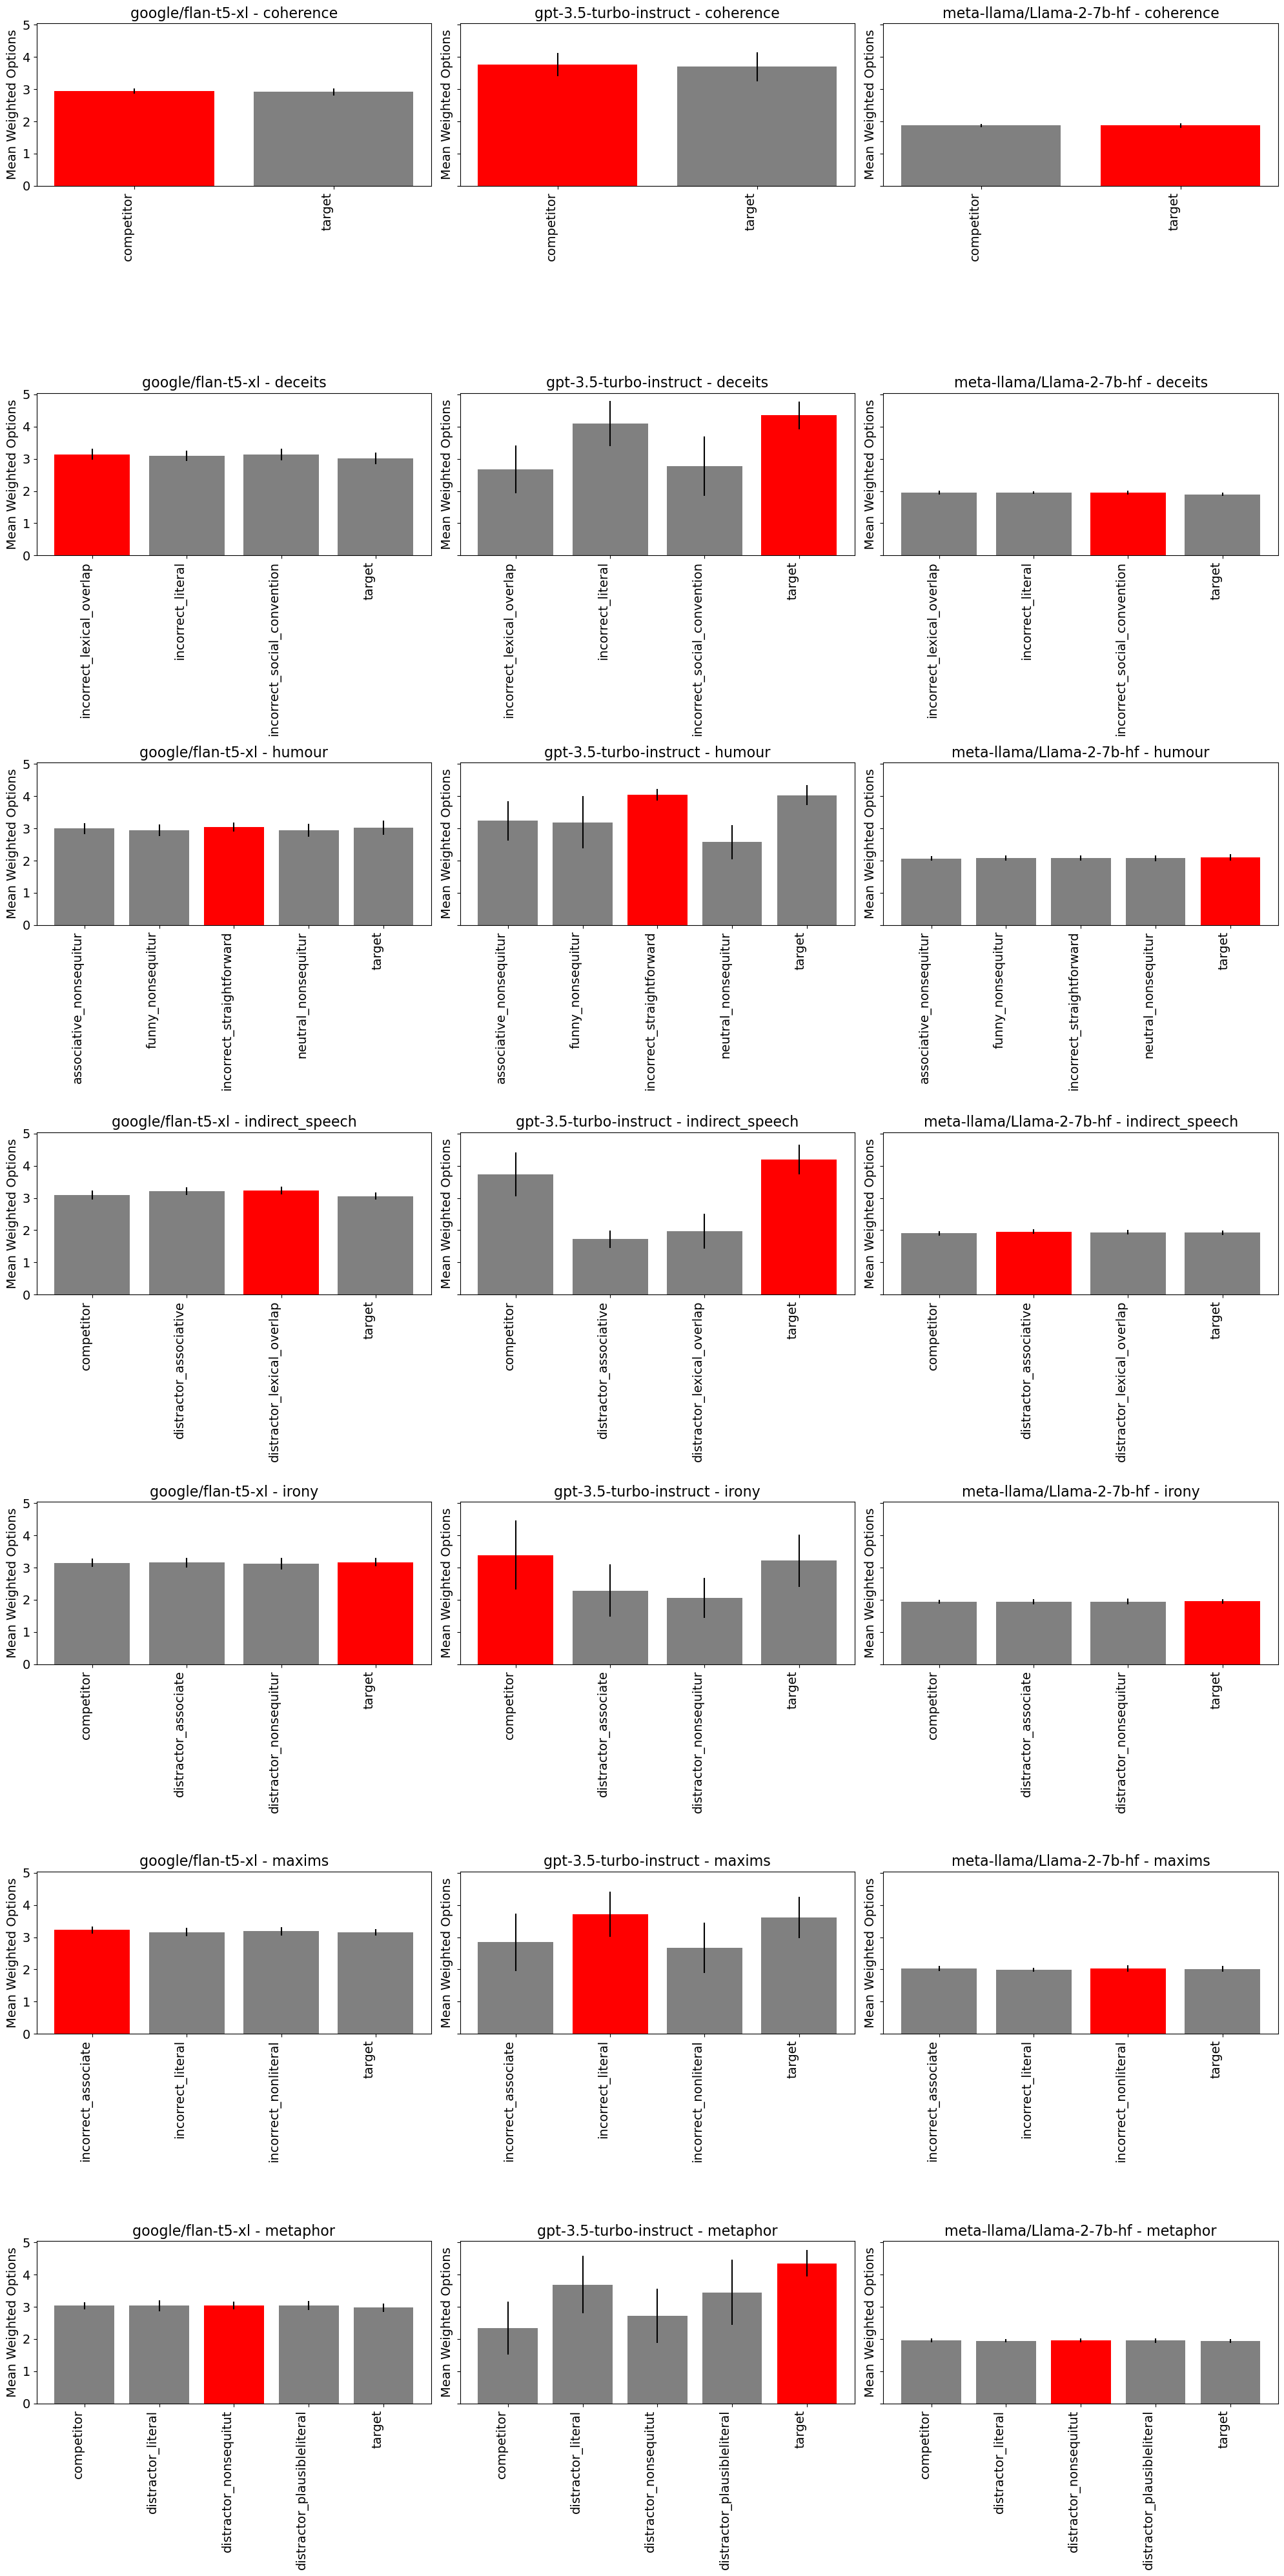

In [10]:
# Manually creating a grid of subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterating over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_df_no_scale[(grouped_df_no_scale['model_name'] == model) & 
                                     (grouped_df_no_scale['phenomenon'] == phenomenon)]
        
        # Determining the bar color based on the highest mean
        colors = ['red' if val == subset['mean'].max() else 'gray' for val in subset['mean']]
        
        ax.bar(subset['option_names'], subset['mean'], color=colors, yerr=subset['std'])
        ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
        ax.set_xlabel('')
        ax.set_ylabel('Mean Weighted Options')

        # Use FixedLocator to set ticks
        ax.xaxis.set_major_locator(FixedLocator(range(len(subset['option_names']))))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

       # Remove all lines on background
        ax.grid(False)
        #sns.despine(left=True, bottom=True, ax=ax)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

        
# Adjust layout
fig.tight_layout()
plt.show()

In [11]:
# Define the path to save the plot as PDF
save_path = "plots/rating_argmax.w.score_options_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_argmax.w.score_options_by_model_phenomenon.pdf'

## Plot of weigted score of target option against option categories grouped by phenomenon and model

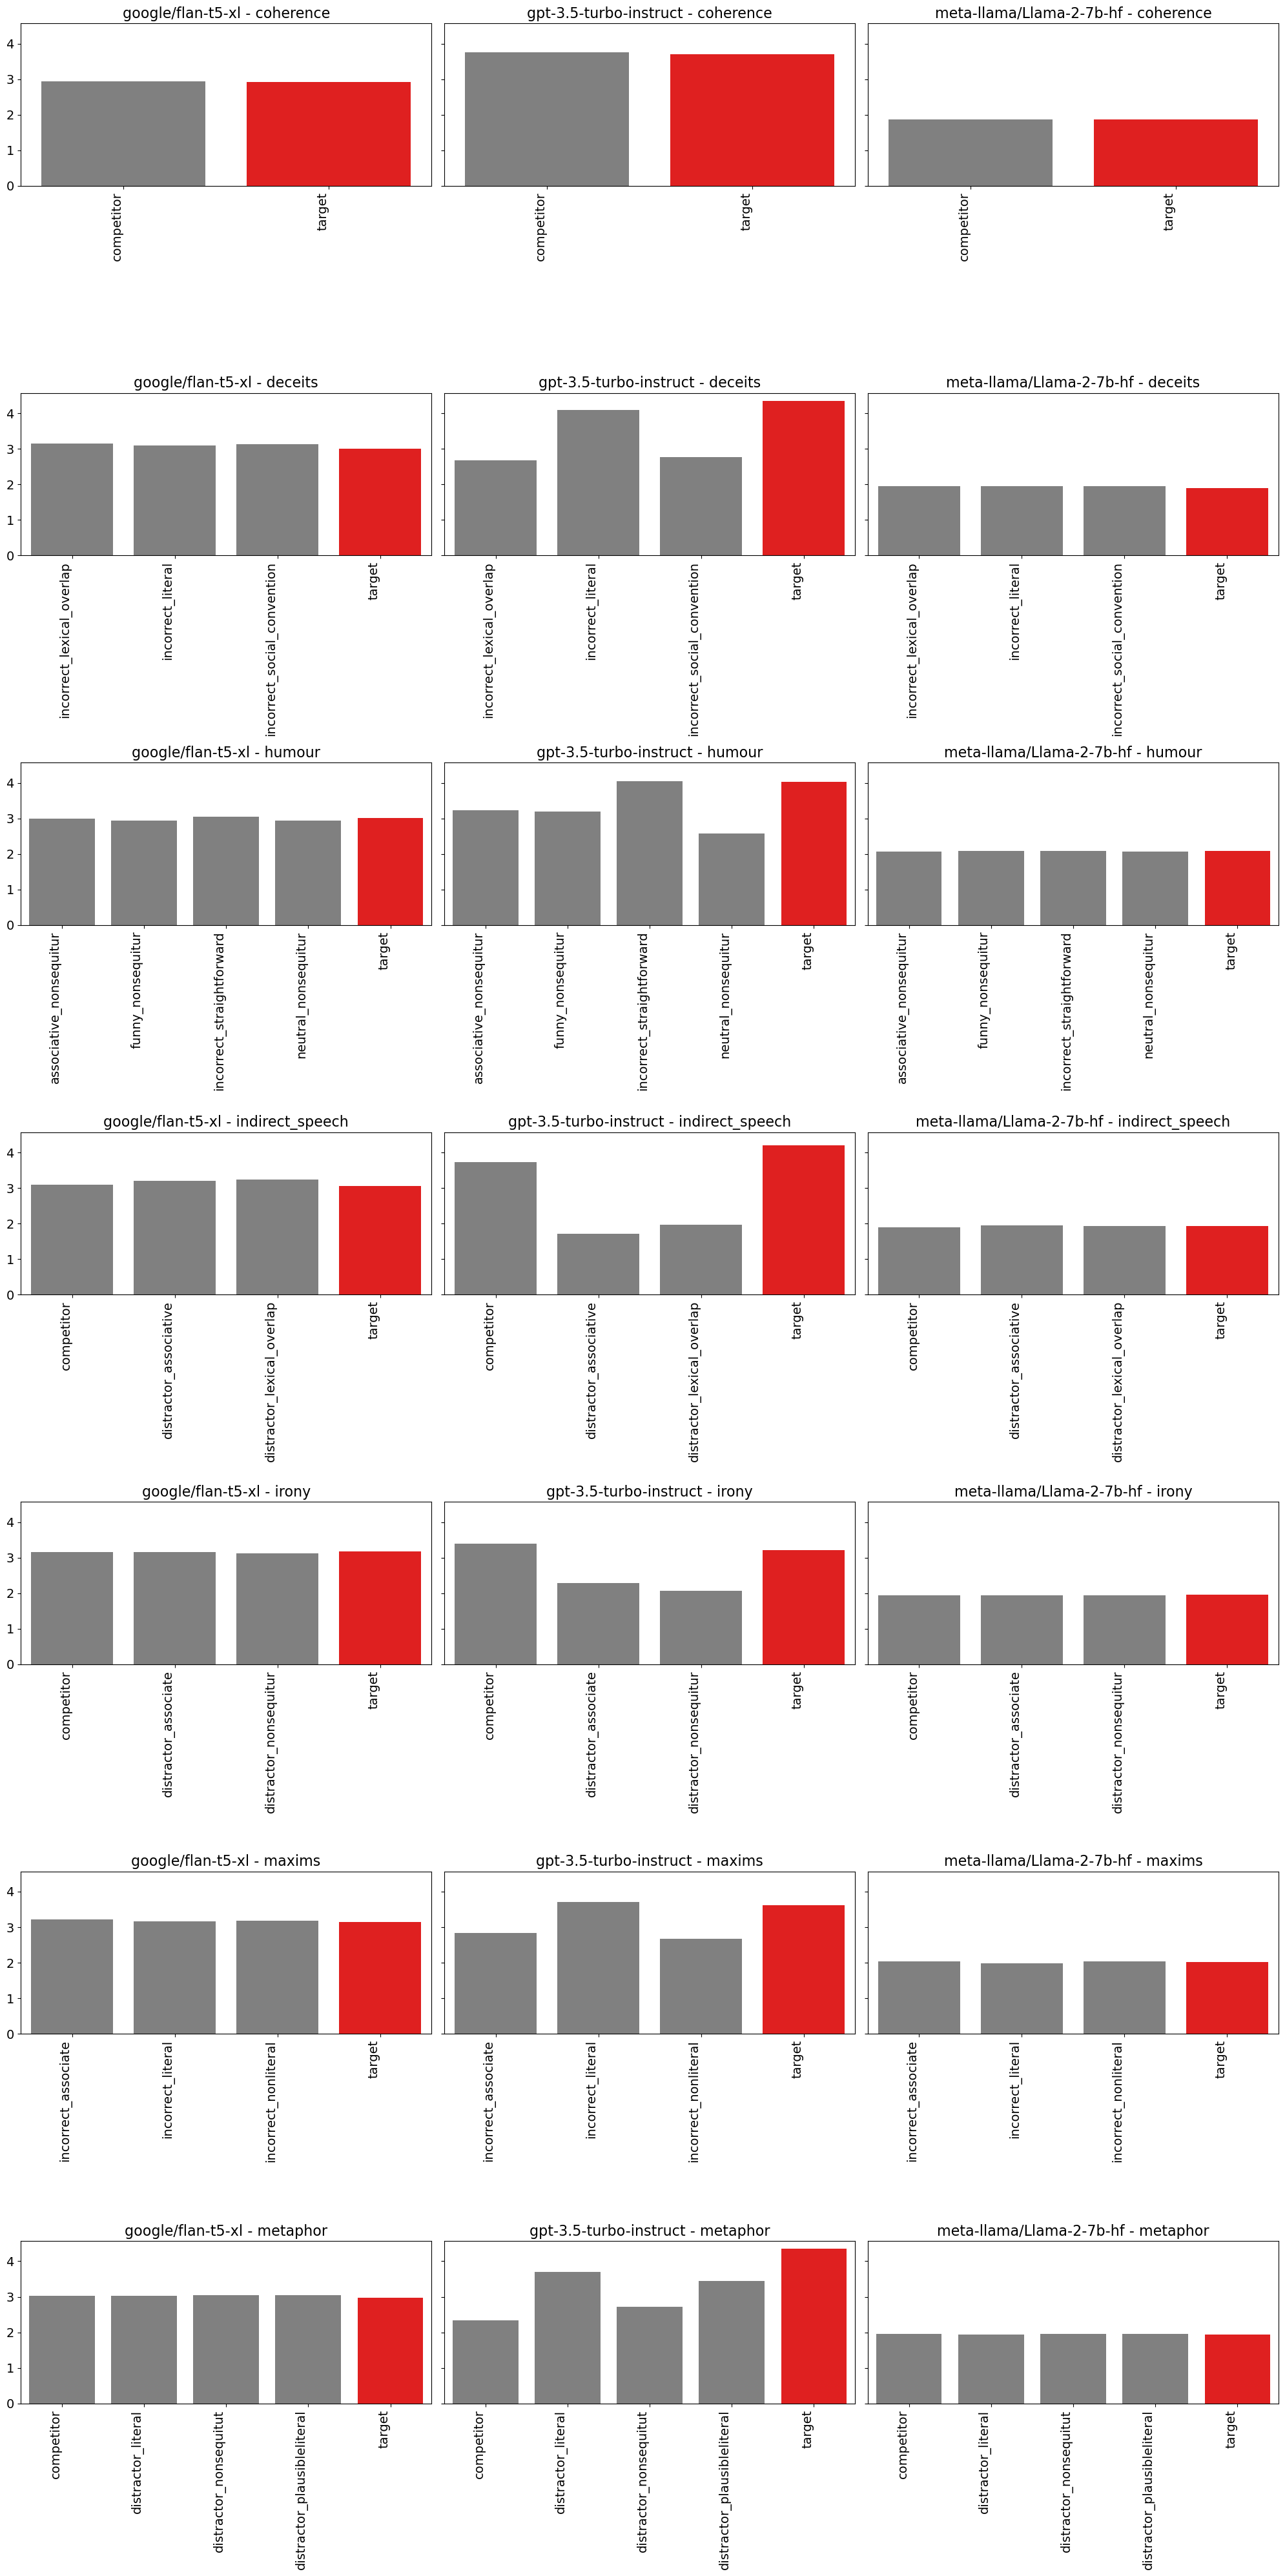

In [12]:
# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = grouped_df_no_scale[(grouped_df_no_scale['model_name'] == model) & (grouped_df_no_scale['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='option_names', y='mean', data=subset, ax=ax, palette=palette, hue='option_names')
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['option_names']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.grid(True, axis='y')

            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [13]:
# Define the path to save the plot as PDF
save_path = "plots/rating_target_w.score_distribution_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_target_w.score_distribution_by_model_phenomenon.pdf'

## Plot of proportion of choosen target against option categories grouped by phenomenon and model

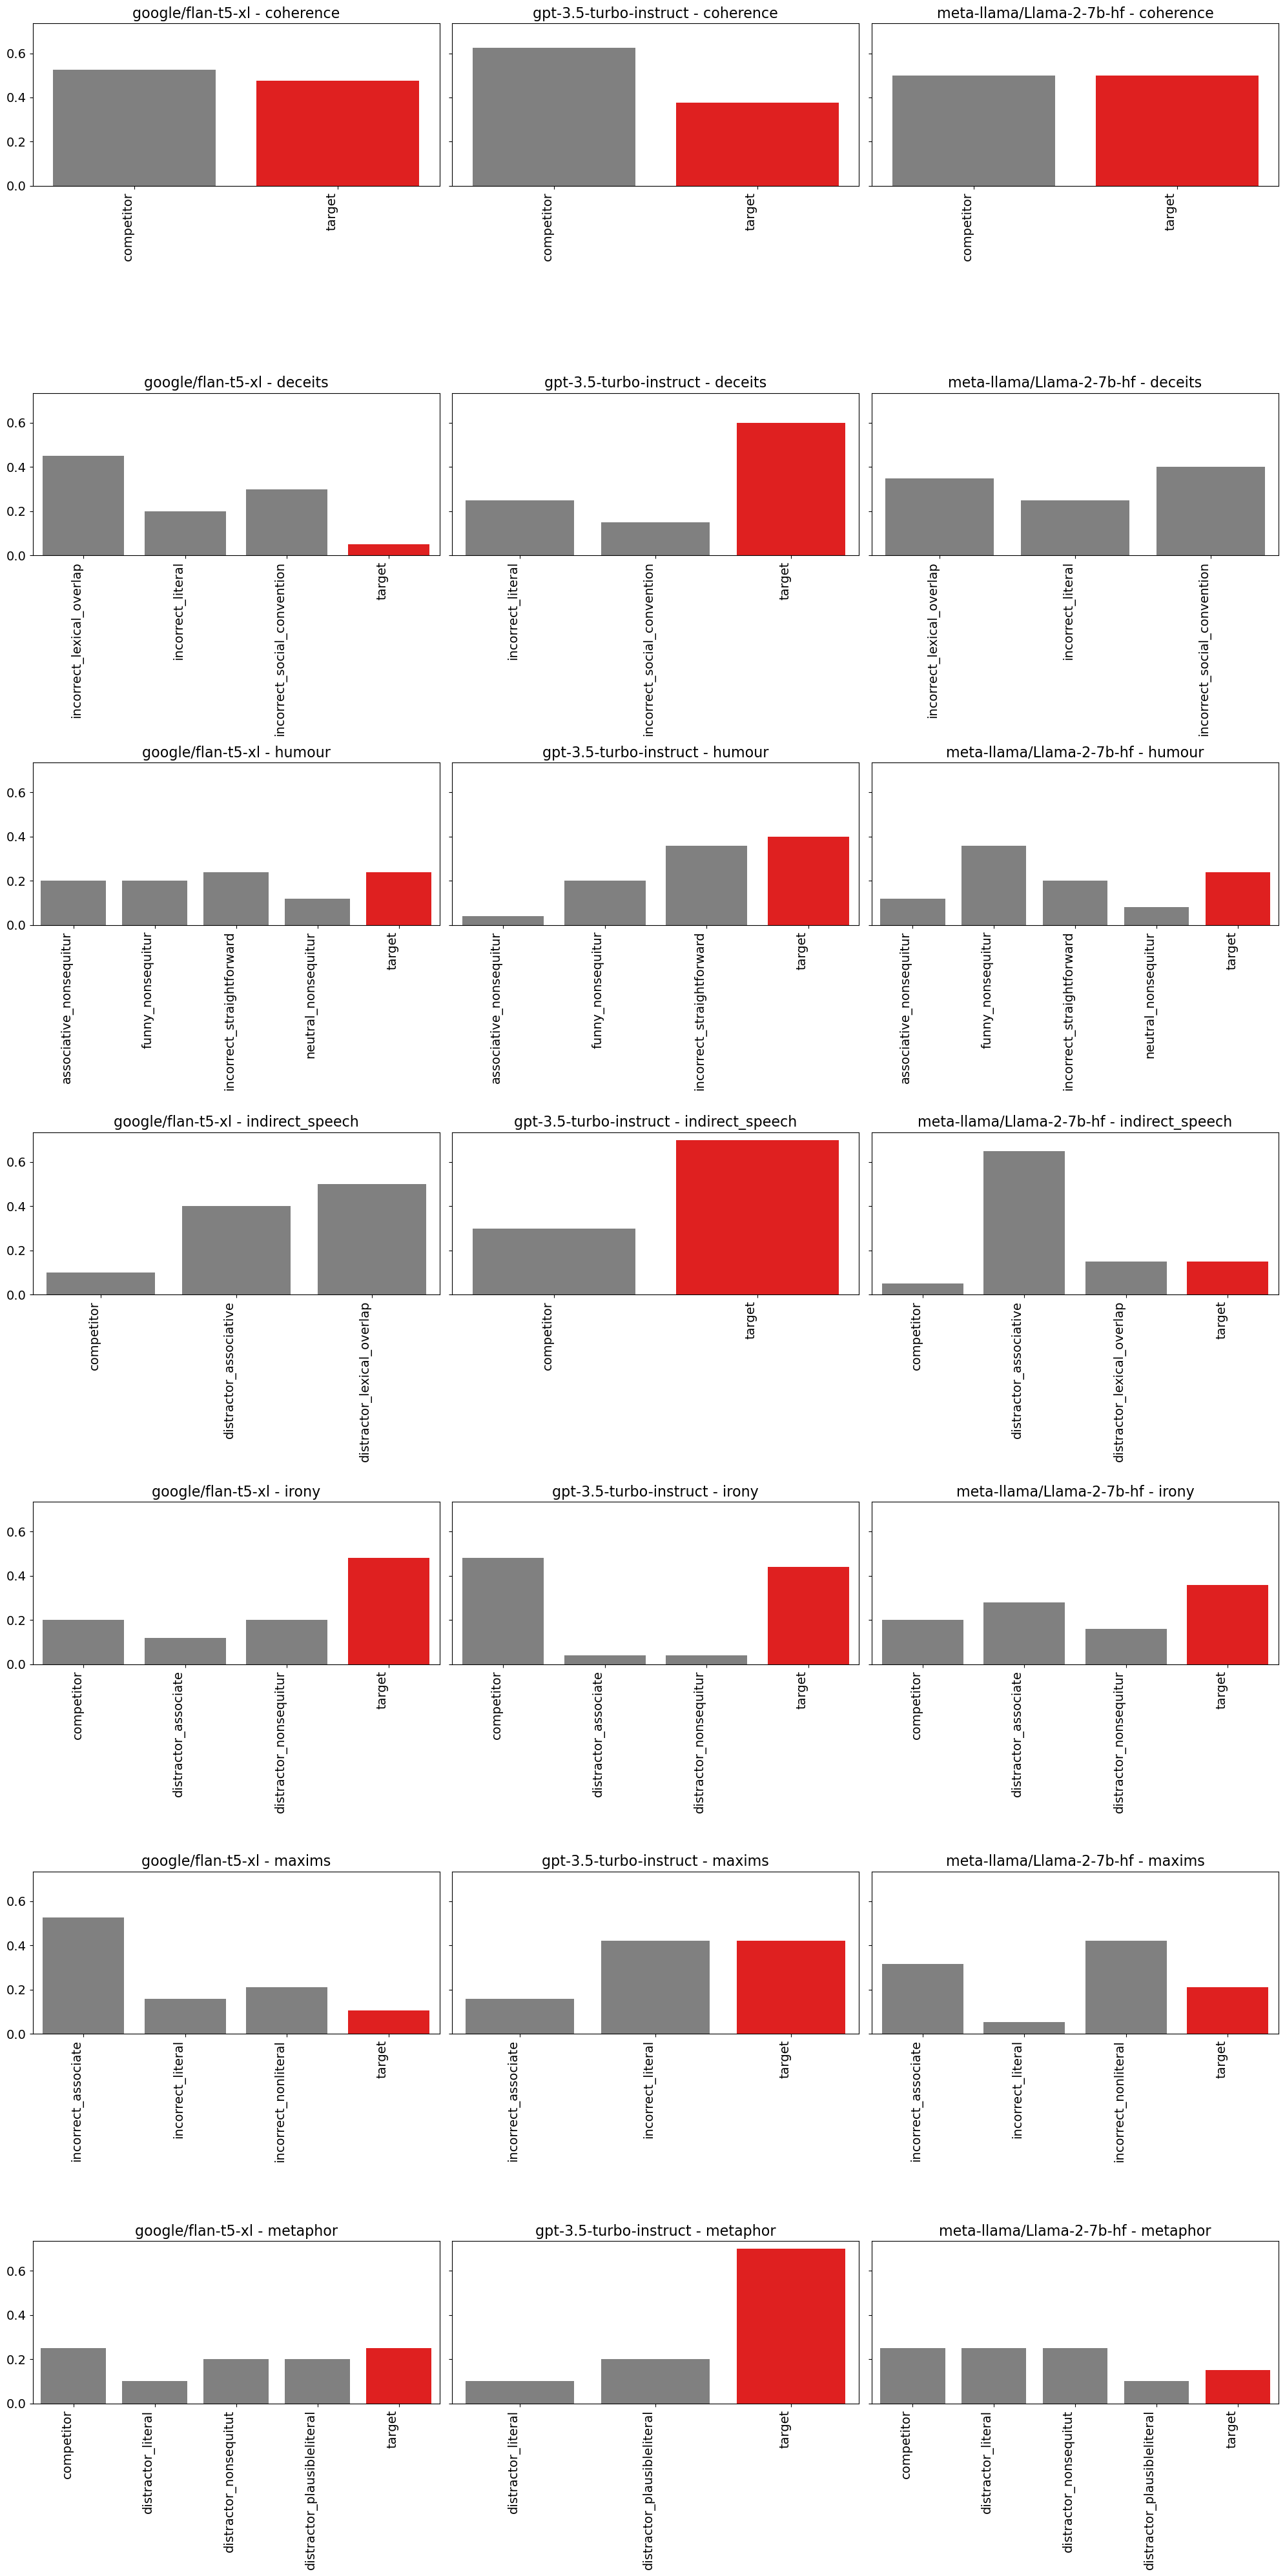

In [14]:
# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in df_no_scale['chosen_option'].unique()}

# Calculating the proportion of each chosen_option for each model and phenomenon combination
proportion_data = df_no_scale.groupby(['model_name', 'phenomenon', 'chosen_option']).size().reset_index(name='counts')

# Calculating the proportion of each chosen_option for each model and phenomenon combination again
total_counts = proportion_data.groupby(['model_name', 'phenomenon'])['counts'].transform('sum')
proportion_data['proportion'] = proportion_data['counts'] / total_counts

# Plotting the proportions
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, hue='chosen_option', palette=palette)
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            
            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['chosen_option']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            
            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


## Plot of proportion of choosen target against target vs. others grouped by phenomenon and model

In [15]:
# Re-encode the option_names column to be more readable
df_no_scale_binary = df_no_scale.copy()
df_no_scale_binary.loc[:,'chosen_option'] = np.where(df_no_scale['chosen_option'] == 'target', 'target', 'others')

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in df_no_scale_binary['chosen_option'].unique()}

# Calculating the proportion of each chosen_option for each model and phenomenon combination
proportion_data = df_no_scale_binary.groupby(['model_name', 'phenomenon', 'chosen_option']).size().reset_index(name='counts')

# Calculating the proportion of each chosen_option for each model and phenomenon combination again
total_counts = proportion_data.groupby(['model_name', 'phenomenon'])['counts'].transform('sum')
proportion_data['proportion'] = proportion_data['counts'] / total_counts

                  model_name       phenomenon chosen_option  counts
0          google/flan-t5-xl        coherence        others      42
1          google/flan-t5-xl        coherence        target      38
2          google/flan-t5-xl          deceits        others      76
3          google/flan-t5-xl          deceits        target       4
4          google/flan-t5-xl           humour        others      95
5          google/flan-t5-xl           humour        target      30
6          google/flan-t5-xl  indirect_speech        others      80
7          google/flan-t5-xl            irony        others      52
8          google/flan-t5-xl            irony        target      48
9          google/flan-t5-xl           maxims        others      68
10         google/flan-t5-xl           maxims        target       8
11         google/flan-t5-xl         metaphor        others      75
12         google/flan-t5-xl         metaphor        target      25
13    gpt-3.5-turbo-instruct        coherence   

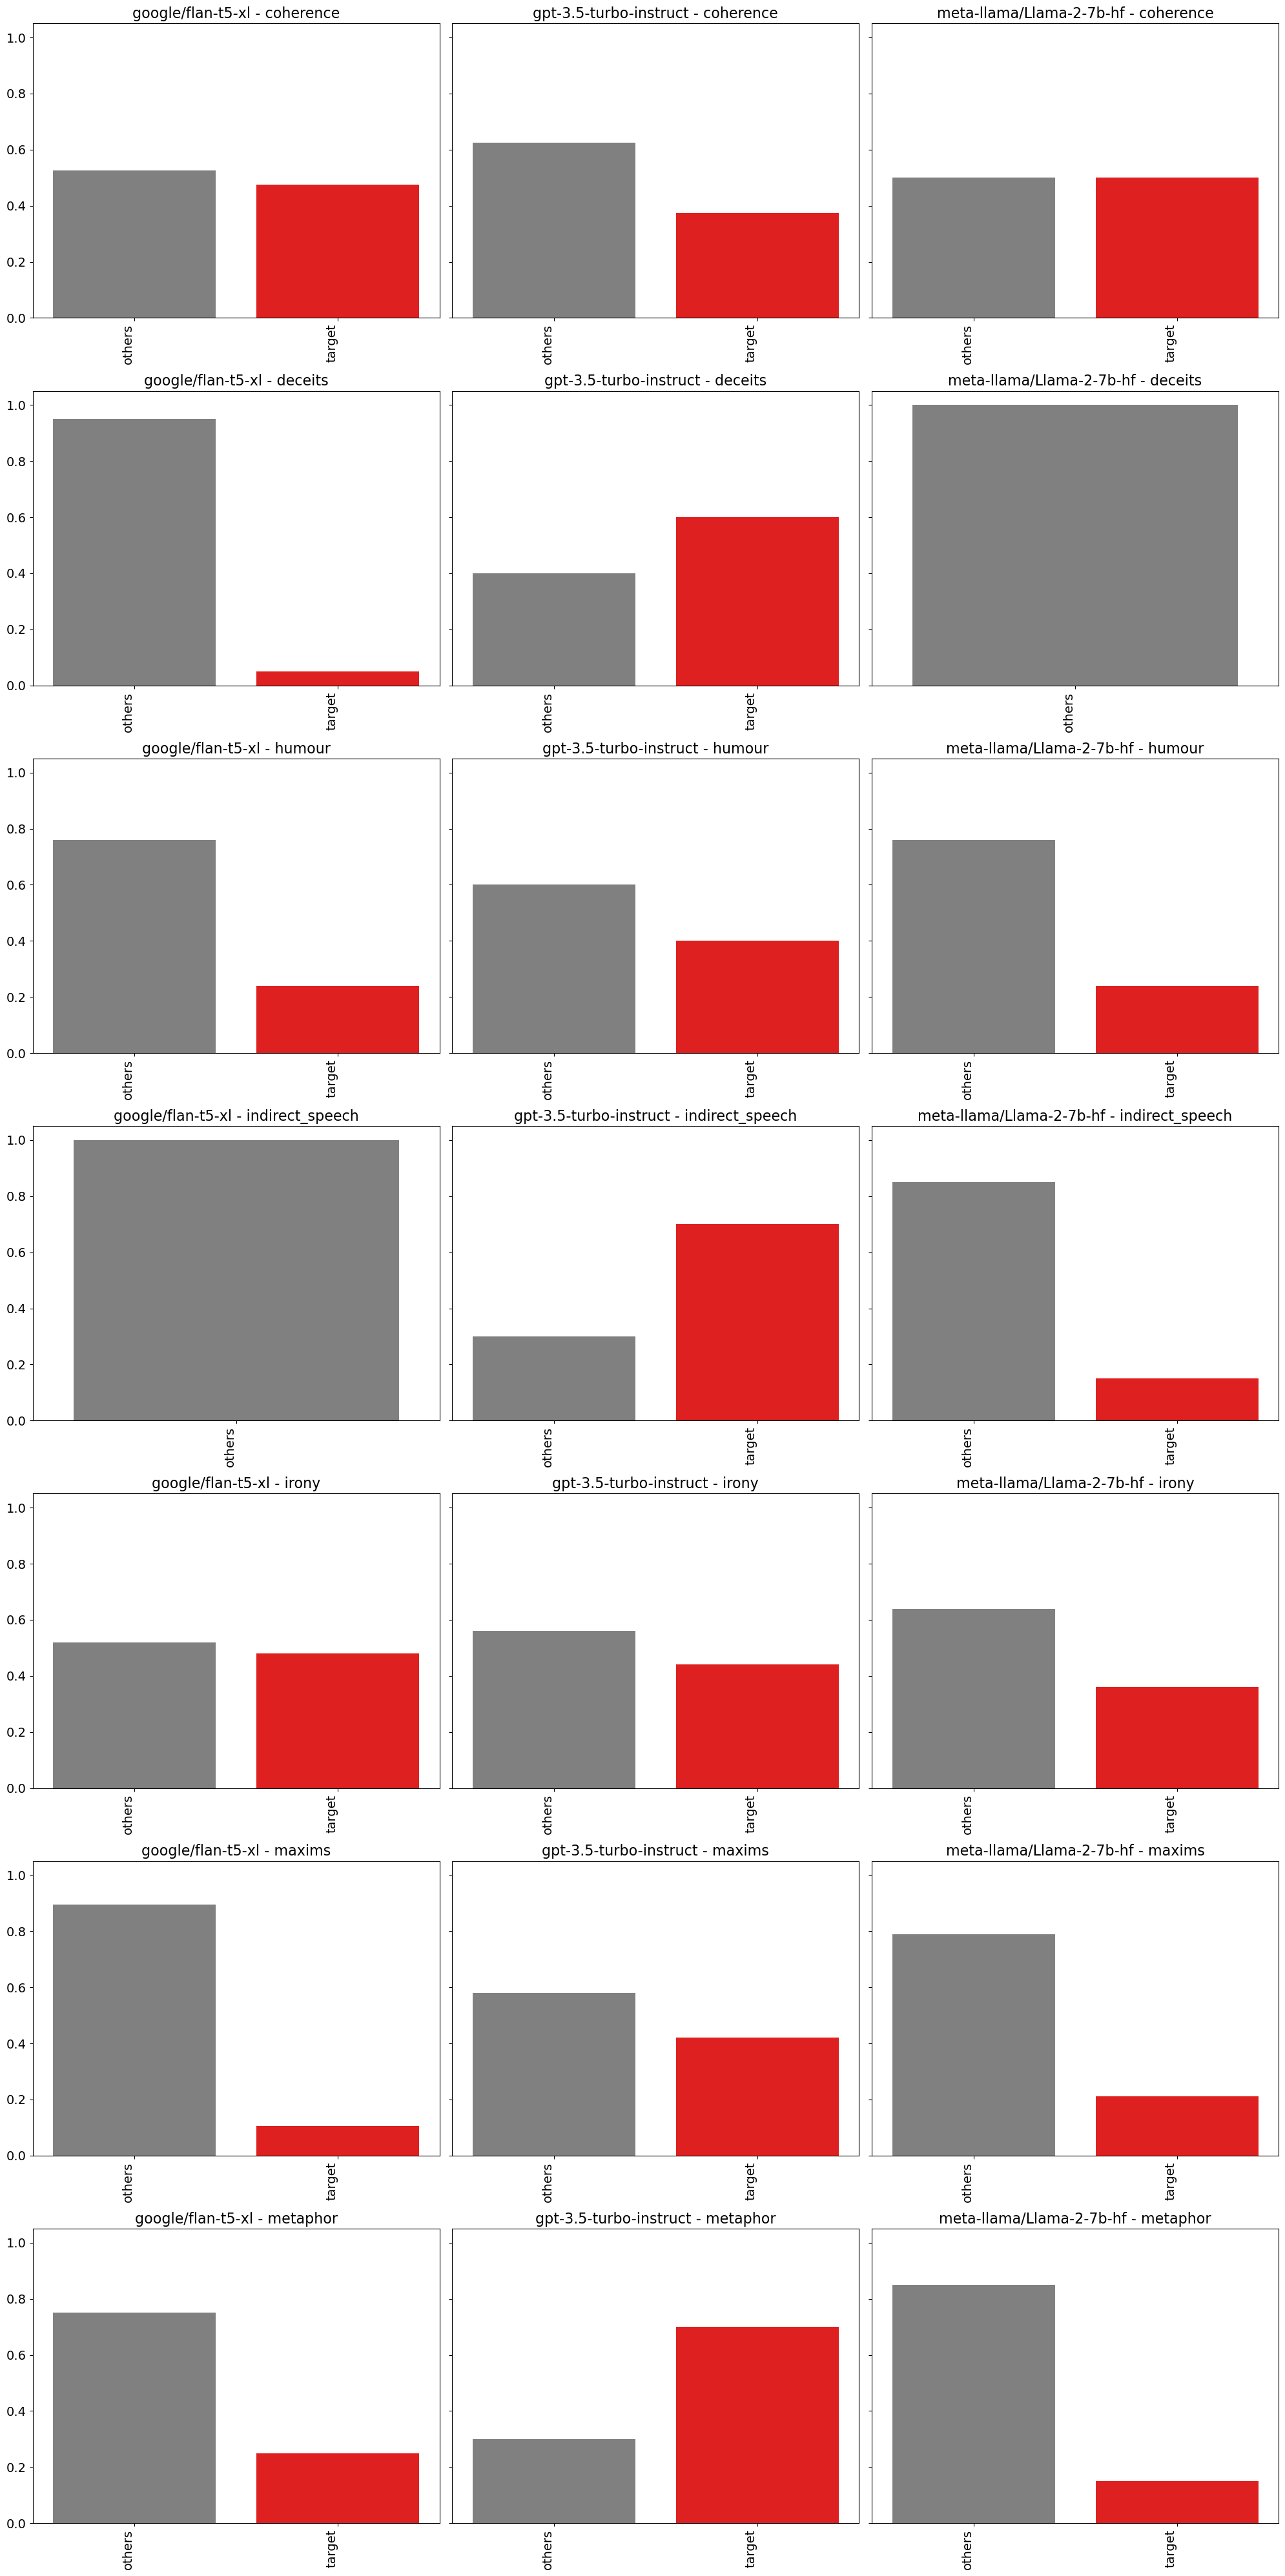

In [16]:

# Plotting the proportions
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
        if not subset.empty:
            sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, hue='chosen_option', palette=palette)
            ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
            ax.set_xlabel('')
            ax.set_ylabel('')

            
            # Use FixedLocator to set ticks
            ax.xaxis.set_major_locator(FixedLocator(range(len(subset['chosen_option']))))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            
            # Remove all lines on background
            ax.grid(False)
            #sns.despine(left=True, bottom=True, ax=ax)

            # Set title with larger font size
            ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
            # Increase tick label size
            ax.tick_params(axis="x", rotation=90, labelsize=14)
            ax.tick_params(axis="y", labelsize=14)
            
            # Increase axis label size
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# Adjust layout
fig.tight_layout()
plt.show()


In [17]:
# Define the path to save the plot as PDF
save_path = "plots/rating_propo.target_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/rating_propo.target_by_model_phenomenon.pdf'

## Export CSV for further analysis

In [18]:
# Take a look
df_no_scale_binary.head()

,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,scale,rating_options,weighted_options,chosen_option,token_cond_log_probs,prior_token_log_probs,null_prior_token_log_probs
80,meta-llama/Llama-2-7b-hf,0.1,0,1,deceits,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He does not want to get into trouble for not s...,target,appropriate,"very inappropriate, inappropriate, neutral, ap...",1.883455,others,"[[-10.325904846191406, -4.785717964172363], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.150535583496094, -5.103446960449219], [-..."
81,meta-llama/Llama-2-7b-hf,0.1,0,1,deceits,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He has been reading for some time.,incorrect_literal,appropriate,"very inappropriate, inappropriate, neutral, ap...",1.931843,others,"[[-10.107025146484375, -4.639193058013916], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.634095191955566, -5.153406620025635], [-..."
82,meta-llama/Llama-2-7b-hf,0.1,0,1,deceits,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He wants his mom to believe that he has been w...,incorrect_lexical_overlap,appropriate,"very inappropriate, inappropriate, neutral, ap...",1.924816,others,"[[-10.181174278259277, -4.870183944702148], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.855224609375, -4.926755905151367], [-10...."
83,meta-llama/Llama-2-7b-hf,0.1,0,1,deceits,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He does not want to offend his mom by not read...,incorrect_social_convention,appropriate,"very inappropriate, inappropriate, neutral, ap...",1.940945,others,"[[-10.358108520507812, -4.807172775268555], [-...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.363120079040527, -4.919028282165527], [-..."
84,meta-llama/Llama-2-7b-hf,0.1,0,2,deceits,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He does not want to hurt Monica by saying that...,target,appropriate,"very inappropriate, inappropriate, neutral, ap...",1.947396,others,"[[-9.394673347473145, -4.746034622192383], [-9...","[[-13.373932838439941, -2.9205374717712402], [...","[[-10.561054229736328, -4.877218723297119], [-..."


In [19]:
# Add a column to indicate metrics
df_no_scale_binary['metrics'] = 'rating'

In [27]:
# Save csv file
csv_out_path = "processed_data/rating_binary_no_scale.csv"

# Ensure the directory exists
os.makedirs(os.path.dirname(csv_out_path), exist_ok=True)

# Save the csv to the specified path
df_no_scale_binary.to_csv(csv_out_path, index=False)

In [21]:
# coherence_not_target_df = concatenated_df[(concatenated_df['phenomenon'] == 'coherence') & 
#                                           (concatenated_df['chosen_option'] != 'target')]

# coherence_not_target_df

In [22]:
# # Plotting the proportions
# fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=True)

# for i, phenomenon in enumerate(unique_phenomena):
#     for j, model in enumerate(unique_models):
#         ax = axes[i, j]
#         subset = proportion_data[(proportion_data['model_name'] == model) & (proportion_data['phenomenon'] == phenomenon)]
#         if not subset.empty:
#             sns.barplot(x='chosen_option', y='proportion', data=subset, ax=ax, palette=palette, hue='chosen_option')
#             ax.set_title(f'Model: {model} | Phenomenon: {phenomenon}')
#             ax.set_xlabel('')
#             ax.set_ylabel('')

            
#             # Use FixedLocator to set ticks
#             ax.xaxis.set_major_locator(FixedLocator(range(len(subset['chosen_option']))))
#             ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            
#             # Remove all lines on background
#             ax.grid(False)
#             #sns.despine(left=True, bottom=True, ax=ax)

#             # Set title with larger font size
#             ax.set_title(f"{model} - {phenomenon}", fontsize=16)
            
#             # Increase tick label size
#             ax.tick_params(axis="x", rotation=90, labelsize=14)
#             ax.tick_params(axis="y", labelsize=14)
            
#             # Increase axis label size
#             ax.set_xlabel(ax.get_xlabel(), fontsize=14)
#             ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# # Adjust layout
# fig.tight_layout()
# plt.show()

In [23]:
# # Creating a proper name for the plot
# plot_name = "rating_w.score_by_scale_model_phenomenon.pdf"
# plot_path = os.path.join("plots", plot_name)

# # Ensure the plots directory exists
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# # Save the plot
# fig.savefig(plot_path)

# plot_path


In [24]:
# # Subsetting the DataFrame based on the specified criteria
# subset_df = concatenated_df[(concatenated_df['model_name'] == 'gpt-3.5-turbo-instruct') & 
#                             (concatenated_df['scale'] == 'possible')]

# # Grouping the subsetted data by the specified columns and calculating the mean for 'weighted_options'
# grouped_subset_df = subset_df.groupby(['phenomenon', 'option_names', 'item_id', 'model_name', 'scale'])['weighted_options'].agg(['mean']).reset_index()

# grouped_subset_df.head()

# print(grouped_subset_df.shape)
# print(grouped_subset_df.isnull().sum())
# print(grouped_subset_df.head())

In [25]:
# # Extracting unique phenomena from the grouped_subset_df DataFrame
# unique_phenomena_subset = grouped_subset_df['phenomenon'].unique()

# # Use a custom color palette for different option_names
# #palette_subset = sns.color_palette("viridis", len(grouped_subset_df['option_names'].unique()))


# # Use a custom color palette to highlight 'target' response_option
# palette = {response: 'gray' if response != 'target' else 'red' for response in grouped_subset_df['option_names'].unique()}

# # Set up the grid layout for the subplots
# fig, axes = plt.subplots(len(unique_phenomena_subset), 1, figsize=(10, 40), sharey=True)

# # If there's only one phenomenon, we make axes an array for consistent indexing
# if len(unique_phenomena_subset) == 1:
#     axes = [axes]

# # Iterate over each phenomenon to create individual subplots
# for i, phenomenon in enumerate(unique_phenomena_subset):
#     ax = axes[i]
#     subset = grouped_subset_df[grouped_subset_df['phenomenon'] == phenomenon]
#     if not subset.empty:
#         colors = ['red' if val == subset['mean'].max() else 'gray' for val in subset['mean']]
#         sns.barplot(x='option_names', y='mean', data=subset, ax=ax, palette=palette, hue='option_names')
#         #ax.bar(subset['phenomenon'], subset['mean'], color=colors)
#         ax.set_ylabel('Mean Weighted Options')
#         ax.set_title(f"Phenomenon: {phenomenon}")
#         ax.set_xlabel('')
#         ax.set_ylabel('')

#         # Use FixedLocator to set ticks
#         ax.xaxis.set_major_locator(FixedLocator(range(len(subset['option_names'].unique()))))
#         ax.set_xticklabels(subset['option_names'].unique(), rotation=45, ha="right")
#         #ax.grid(True, axis='y')

#         # Remove all lines on background
#         ax.grid(False)

#         # Increase tick label size
#         ax.tick_params(axis="x", rotation=90, labelsize=14)
#         ax.tick_params(axis="y", labelsize=14)
        
#         # Increase axis label size
#         ax.set_xlabel(ax.get_xlabel(), fontsize=14)
#         ax.set_ylabel(ax.get_ylabel(), fontsize=14)

# # Adjust layout
# fig.tight_layout()
# plt.show()


In [26]:
# # Creating a proper name for the plot
# plot_name = "rating_w.score_gpt_possible.pdf"
# plot_path = os.path.join("plots", plot_name)

# # Ensure the plots directory exists
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# # Save the plot
# fig.savefig(plot_path)

# plot_path
